In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from skimage.io import imread, imsave, imshow
import numpy as np

In [3]:
im = imread('img.png')

In [4]:
def extend_height(image, extended_image, width, height, addition = 0):
    for h in range(height - 1, -1, -1):
        for i in range(image.shape[1] + addition):
            extended_image[h, i + width] \
                = extended_image[h + 1 : h + 1 + height, i : i + height * 2 + 1].mean(axis=0).mean(axis=0)
            extended_image[-h - 1, i + width] \
                = extended_image[-h - 1 - height : -h - 1, i : i + height * 2 + 1].mean(axis=0).mean(axis=0)

In [5]:
def extend_width(image, extended_image, width, height, addition = 0):
    for w in range(width - 1, -1, -1):
        for i in range(image.shape[0] + addition):
            extended_image[i + height, w] \
                = extended_image[i : i + height * 2 + 1, w + 1 : w + 1 + width].mean(axis = 0).mean(axis = 0)
            extended_image[i + height, -w - 1] \
                = extended_image[i : i + height * 2 + 1, -w - 1 - width : -w - 1].mean(axis = 0).mean(axis = 0)

In [6]:
def extend_image(image, width = 1, height = 1):
    shape = image.shape

    fatting = width * image.shape[0] < height * image.shape[1]

    if fatting:
        width = 2 * width
    else:
        height = 2 * height

    extended_image = np.ones((shape[0] + height * 2, shape[1] + width * 2, shape[2]), np.uint8)
    extended_image[:] = 256 / 2
    extended_image[height : -height if height > 0 else None, width : -width if width > 0 else None] = image

    if fatting:
        extend_width(image, extended_image, width, height)
        width = int(width / 2)
        extend_height(image, extended_image, width, height, width * 2)
        return extended_image[ : , width : -width if width > 0 else None]
    else:
        extend_height(image, extended_image, width, height)
        height = int(height / 2)
        extend_width(image, extended_image, width, height, height * 2)
        return extended_image[height : -height if height > 0 else None, : ]

In [7]:
def filter_box(image, width=3, height=3):
    side_extension = int(width / 2)
    vert_extension = int(height / 2)
    extended_image = extend_image(image, side_extension, vert_extension)
    res = np.zeros(image.shape, dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r = extended_image[i : i + height, j : j + width, 0].mean()
            g = extended_image[i : i + height, j : j + width, 1].mean()
            b = extended_image[i : i + height, j : j + width, 2].mean()
            res[i, j] = (r,g,b)
    return res

In [8]:
def filter_median(image, width=3, height=3):
    side_extension = int(width / 2)
    vert_extension = int(height / 2)
    extended_image = extend_image(image, side_extension, vert_extension)
    res = np.zeros(image.shape, dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r = np.median(extended_image[i : i + height, j : j + width, 0])
            g = np.median(extended_image[i : i + height, j : j + width, 1])
            b = np.median(extended_image[i : i + height, j : j + width, 2])
            res[i, j] = (r,g,b)
    return res

In [20]:
def filter_convolution(image, conv):
    csum = conv.sum()
    if csum == 0:
        csum = 1
    width = conv.shape[1]
    height = conv.shape[0]
    side_extension = int(width / 2)
    vert_extension = int(height / 2)
    extended_image = extend_image(image, side_extension, vert_extension)
    res = np.zeros(image.shape, dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r = (extended_image[i : i + height, j : j + width, 0] * conv).sum() / csum
            g = (extended_image[i : i + height, j : j + width, 1] * conv).sum() / csum
            b = (extended_image[i : i + height, j : j + width, 2] * conv).sum() / csum
            res[i, j] = np.clip((r,g,b), 0, 255)
    return res

In [10]:
def filter_gaussian(image, n):
    m = np.arange(n)
    mu = (n - 1) / 2
    sigma = mu / 3
    hres = (1 / ((2 * np.pi * sigma ** 2) ** .5)) * np.exp(-((m - mu) ** 2)
                                                        /#------------------
                                                          (2 * sigma ** 2))
    vres = hres.copy()
    hres.shape = (n, 1)
    vres.shape = (1, n)
    hf = filter_convolution(image, hres)
    res = filter_convolution(hf, vres)
    return res

In [11]:
def rgb2gray(rgb):
    single = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    rgb_gray = np.uint8(np.stack((single, single, single), 2))
    return rgb_gray

In [23]:
def filter_prewitt(image):
    gray = rgb2gray(image)
    operator_y = np.array(((1,1,1),(0,0,0),(-1,-1,-1)))
    yed = filter_convolution(gray, operator_y)
#     operator_x = np.array(((1,0,-1),(1,0,-1),(1,0,-1)))
#     res = filter_convolution(yed, operator_x)
    return yed

In [29]:
def filter_roberts(image):
    gray = rgb2gray(image)
    operator = np.array(((1,0),(0,-1)))
    res = filter_convolution(image, operator)
    return res

In [32]:
wah_robers = filter_roberts(im)

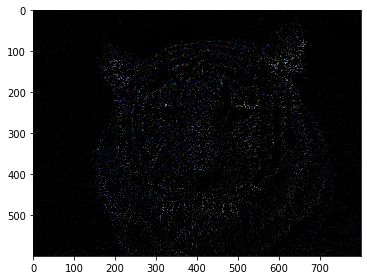

In [33]:
imshow(wah_robers)

In [34]:
imsave('roberts.png', wah_robers)

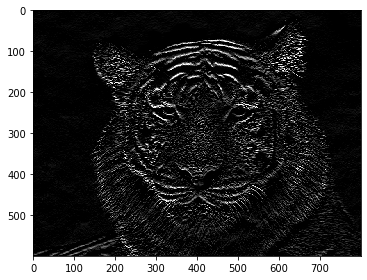

In [25]:
imshow(wah)